In [1]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import open_clip
import numpy as np
# import matplotlib.pyplot as plt
import torch
import torchvision
import wandb
# from diffusers.model

/mmfs1/gscratch/sewoong/anasery/synthetic_data/diffusion_vs_clip/.venv/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Creating ColoredMNIST

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define the color map (e.g., 10 colors for 10 classes)
colors = [
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [128, 0, 0],    # Maroon
    [128, 128, 0],  # Olive
    [0, 128, 0],    # Green
    [0, 128, 128]   # Teal
]

# Get random characters for labels
label_characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
color_characters = ['R', 'G', 'B', 'Y', 'C', 'M', 'M', 'O', 'G', 'T']

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='.', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='.', train=False, transform=transform, download=True)


def colorize_image(img, color):
    # Convert the grayscale image to a colored image
    # img = img.squeeze(0).numpy()
    # img_new = 1. - img
    # img_colored = np.stack([img_new * color[i] / 255 for i in range(3)], axis=0)
    # img_colored = img_colored + np.expand_dims(img_new, 0)
    # img_colored = np.clip(img_colored, 0, 1)
    img = img.squeeze(0).numpy()
    background_img = np.ones((3, 28, 28))
    img_colored = np.stack([background_img[i] * color[i] / 255 for i in range(3)], axis=0)
    img_colored = img_colored + np.expand_dims(img, 0)
    img_colored = np.clip(img_colored, 0, 1)
    return torch.tensor(img_colored, dtype=torch.float32)

def create_colored_dataset(dataset):
    colored_dataset = []
    for img, label in dataset:
        color = colors[label < 5]
        img_colored = colorize_image(img, color)
        prompt = f"{label_characters[label]} {color_characters[int(label < 5)]}"
        colored_dataset.append({'image': img_colored, 'label': label, 'color': color, 'prompt': prompt})
    return colored_dataset

# Create colored MNIST datasets
colored_mnist_train = create_colored_dataset(mnist_train)
colored_mnist_test = create_colored_dataset(mnist_test)

train_dataloader = torch.utils.data.DataLoader(colored_mnist_train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(colored_mnist_test, batch_size=32, shuffle=False)

## Defining the models

In [26]:
unet = UNet2DConditionModel(
            sample_size=32,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(128, 128, 256, 256, 512, 512),
            cross_attention_dim=512,
            down_block_types=(
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
            ),
            up_block_types=(
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        ).cuda()
# if accepts_prediction_type:
#     noise_scheduler = DDPMScheduler(
#         num_train_timesteps=args.ddpm_num_steps,
#         beta_schedule=args.ddpm_beta_schedule,
#         prediction_type=args.prediction_type,
#     )
# else:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # , beta_schedule=args.ddpm_beta_schedule)
tokenizer = open_clip.get_tokenizer('ViT-B-32')  # CLIPTokenizer.from_pretrained(
#     "", subfolder="tokenizer", revision=0
# )  # Ensure that this is consistent with CLIP training that we do
clip = open_clip.create_model('ViT-B-32')
text_encoder = torch.nn.Sequential(clip.token_embedding, clip.transformer).cuda()
# CLIPTextModel.from_pretrained(
#             args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, variant=args.variant
#         )
optimizer = torch.optim.AdamW(
    [x for x in unet.parameters()]+[x for x in text_encoder.parameters()],  # Add CLIP params here
    lr=1e-2
    # lr=args.learning_rate,
    # betas=(args.adam_beta1, args.adam_beta2),
    # weight_decay=args.adam_weight_decay,
    # eps=args.adam_epsilon,
)

### Some training utils
Defining things for visualizing images etc

In [27]:
from tqdm import tqdm

def reverse_diffusion_step(noisy_image, model, noise_scheduler, t, text_input):
    # Predict the noise to be removed
    noise_pred = model(noisy_image, t, text_input, return_dict=False)[0]
    
    denoised_image = noise_scheduler.step(noise_pred, t, noisy_image).prev_sample    
    # # Compute the next step in the reverse diffusion process
    # alpha_t = noise_scheduler.alphas[t]
    # alpha_t_prev = noise_scheduler.alphas[t - 1] if t > 0 else 1.0
    
    # # Compute the denoised image (simplified example)
    # denoised_image = (noisy_image - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
    
    # # Add some noise for the next step
    # if t > 0:
    #     noise = torch.randn_like(noisy_image).cuda()
    #     denoised_image += (alpha_t_prev - alpha_t).sqrt() * noise
    
    return denoised_image

def visualize(model, text_encoder, tokenizer,  color, label, prompt=None, bsz=1):
    with torch.no_grad():
        model.eval()
        text_encoder.eval()
        if prompt is None:
            prompt = f"{label_characters[label]} {color_characters[int(label < 5)]}"
        tokenized_prompt = tokenizer(prompt).cuda()
        
        
        encoder_hidden_states = text_encoder(tokenized_prompt)[0].unsqueeze(0).repeat(bsz, 1, 1)
                # Generate initial noise
        image_shape = (bsz, 3, 28, 28)  # Define the shape of your images
        initial_noise = torch.randn(image_shape).cuda()
        
        # Reverse diffusion process
        timesteps = torch.arange(999, 0, -1).cuda()

        for t in tqdm(timesteps):
            initial_noise = reverse_diffusion_step(initial_noise, model, noise_scheduler, t, encoder_hidden_states)

        out = torch.clamp(initial_noise, 0, 1)
        return out

## Training Loop

In [30]:
NUM_TRAIN_STEPS = 10000
LOGGING_FREQUENCY = 10
VAL_FREQUENCY = 50 # How often to produce images for visual validation
BATCH_SIZE = 32

curr_loss = 0
train_step = 0
wandb_run = wandb.init(project="diffusion_training_cmnist")
for batch in train_dataloader:

    train_step += 1
    images = batch["image"].to(torch.float32).cuda()
    bsz = images.shape[0]
    # Get noise
    noise = torch.randn_like(images)
    # Get a random timestep
    timesteps = torch.randint(0, 1000, (bsz,), device=noise.device)
    timesteps = timesteps.long()


    # Add noise to the clean images according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    noisy_images = noise_scheduler.add_noise(images, noise, timesteps).cuda()

    
    # Create a prompt
    tokenized_prompt = tokenizer(batch["prompt"]).cuda()
    
    
    encoder_hidden_states = text_encoder(tokenized_prompt)[0].unsqueeze(0).repeat(bsz, 1, 1)

    
    # Predict the noise residual and compute loss
    # print(timesteps[0])
    model_pred = unet(noisy_images, timesteps, encoder_hidden_states.cuda(), return_dict=False)[0]
    loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float())  # this could have different weights!

    loss.backward()
    optimizer.step()
    # lr_scheduler.step()
    optimizer.zero_grad()
    curr_loss += loss.item()
    if train_step % LOGGING_FREQUENCY == 0:
        # Will add to wandb
        print(f"Step {train_step}: Loss {curr_loss/LOGGING_FREQUENCY}")
        curr_loss = 0
        wandb_run.log({"loss": loss.item(), "step": train_step})
    if train_step % VAL_FREQUENCY == 0:
        # Visualize
        out = visualize(unet, text_encoder, tokenizer, batch["color"], batch["label"], batch["prompt"])
        torchvision.utils.save_image(out, f"outputs/out_{train_step}.png")
        wandb_run.log({"image": wandb.Image(out)})    

loss,▁
step,▁
loss,1.25385
step,10


Step 10: Loss 1.0791466295719148
Step 20: Loss 1.0042669177055359
Step 30: Loss 1.0015532612800597
Step 40: Loss 1.0000414490699767
Step 50: Loss 1.0015334367752076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:49<00:00, 20.17it/s]


Step 60: Loss 1.001549780368805
Step 70: Loss 0.9990800261497498
Step 80: Loss 1.000037270784378
Step 90: Loss 1.0023656964302063
Step 100: Loss 0.9997836649417877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:51<00:00, 19.29it/s]


Step 110: Loss 1.0030439615249633
Step 120: Loss 1.001138061285019
Step 130: Loss 1.0016145288944245
Step 140: Loss 1.0011362075805663
Step 150: Loss 1.0014087677001953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:56<00:00, 17.80it/s]


Step 160: Loss 0.9976564347743988
Step 170: Loss 1.0034555852413178
Step 180: Loss 1.0030763566493988
Step 190: Loss 0.9995932102203369
Step 200: Loss 1.002254104614258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:50<00:00, 19.70it/s]


Step 210: Loss 1.001839929819107
Step 220: Loss 1.0012076139450072
Step 230: Loss 1.0029936373233794
Step 240: Loss 1.0008386731147767
Step 250: Loss 1.0005120038986206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:49<00:00, 20.27it/s]


KeyboardInterrupt: 

In [24]:
## Testing the scheduler
images = batch["image"].to(torch.float32).cuda()
bsz = images.shape[0]
# Get noise
noise = torch.randn_like(images)
# Get a random timestep
timesteps = torch.ones(images.shape[0])*0 # torch.randint(0, 4, (bsz,), device=noise.device)
timesteps = timesteps.long().cuda()


# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(images, noise, timesteps).cuda()

torchvision.utils.save_image(noisy_images, f"outputs/noisy_{train_step}.png")
torchvision.utils.save_image(images, f"outputs/clean_{train_step}.png")

# Create a prompt
tokenized_prompt = tokenizer(batch["prompt"]).cuda()


encoder_hidden_states = text_encoder(tokenized_prompt)[0].unsqueeze(0).repeat(bsz, 1, 1)


# Predict the noise residual and compute loss
print(timesteps[0])
model_pred = unet(noisy_images, timesteps, encoder_hidden_states.cuda(), return_dict=False)[0]
torchvision.utils.save_image(noisy_images[0], f"outputs/noisy_{train_step}.png")
torchvision.utils.save_image(images[0], f"outputs/clean_{train_step}.png")
torchvision.utils.save_image(model_pred[0], f"outputs/pred_{train_step}.png")
denoised_image = noise_scheduler.step(noise[0], timesteps[0]+1, noisy_images[0]).prev_sample
torchvision.utils.save_image(denoised_image, f"outputs/denoised_{train_step}.png")  
torchvision.utils.save_image(torch.abs(denoised_image-noisy_images[0]), f"outputs/denoised_diff_{train_step}.png")

tensor(0, device='cuda:0')


## Inference with diffusion

In [10]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import open_clip
import numpy as np
# import matplotlib.pyplot as plt
import torch
import torchvision
import wandb
# from diffusers.model

import torch
from torchvision import datasets, transforms
import numpy as np
import random
from tqdm import tqdm

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define the color map (e.g., 10 colors for 10 classes)
colors = [
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [128, 0, 0],    # Maroon
    [128, 128, 0],  # Olive
    [0, 128, 0],    # Green
    [0, 128, 128]   # Teal
]

# Get random characters for labels
label_characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
color_characters = ['R', 'G', 'B', 'Y', 'C', 'M', 'M', 'O', 'G', 'T']

LOSS_FN = 'siglip'
VISION_TOWER = 'vit'
LR = 5e-4
TRAIN_SIGNAL = 'label_color'

# Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                ])
mnist_train = datasets.MNIST(root='.', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='.', train=False, transform=transform, download=True)


def colorize_image(img, color):
    # Convert the grayscale image to a colored image
    img = img.squeeze(0).numpy()
    background_img = np.ones((3, 32, 32))
    img_colored = np.stack([background_img[i] * color[i] / 255 for i in range(3)], axis=0)
    img_colored = img_colored + np.expand_dims(img, 0)
    img_colored = np.clip(img_colored, 0, 1)
    return torch.tensor(img_colored, dtype=torch.float32)


def create_colored_dataset(dataset, ds_size=1000000):
    colored_dataset = []
    for idx, (img, label) in enumerate(dataset):
        if idx >= ds_size:
            break
        color = colors[label < 5]
        img_colored = colorize_image(img, color)
        prompt = f"{label_characters[label]} {color_characters[int(label < 5)]}"
        colored_dataset.append({'image': img_colored, 'label': label, 'color': color, 'prompt': prompt})
    return colored_dataset

# Create colored MNIST datasets
colored_mnist_test = create_colored_dataset(mnist_test)

test_dataloader = torch.utils.data.DataLoader(colored_mnist_test, batch_size=1, shuffle=False)

# Create colored MNIST datasets
from collections import defaultdict
# Check if model understands shapes and colors

def create_inverted_colored_dataset(dataset):
    # Has different colors than above
    colored_dataset = []
    for img, label in dataset:
        color = colors[label >= 5]
        img_colored = colorize_image(img, color)
        prompt = f"{label_characters[label]} {color_characters[int(label >= 5)]}"
        colored_dataset.append({'image': img_colored, 'label': label_characters[label], 'color': color_characters[int(label >= 5)], 'prompt': prompt})
    return colored_dataset

# Also look at accuracy on original MNIST test set

colored_mnist_inverted = create_inverted_colored_dataset(mnist_test)
inverted_dataloader = torch.utils.data.DataLoader(colored_mnist_inverted, batch_size=1, shuffle=False)


unet = UNet2DConditionModel(
            sample_size=32,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(128, 128, 256, 256, 512, 512, 512),
            # block_out_channels=(128, 256, 512),
            cross_attention_dim=512,
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
            ),
            up_block_types=(
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
        ).cuda()
NUM_TRAIN_STEPS = 500
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_STEPS) # , beta_schedule=args.ddpm_beta_schedule)
tokenizer = open_clip.get_tokenizer('ViT-B-32')  # CLIPTokenizer.from_pretrained(
#     "", subfolder="tokenizer", revision=0
# )  # Ensure that this is consistent with CLIP training that we do
clip = open_clip.create_model('ViT-B-32')
text_encoder = torch.nn.Sequential(clip.token_embedding, clip.transformer).cuda()


def reverse_diffusion_step(noisy_image, model, noise_scheduler, t, text_input):
    # Predict the noise to be removed
    noise_pred = model(noisy_image, t, text_input, return_dict=False)[0] 
    denoised_image = noise_scheduler.step(noise_pred, t, noisy_image).prev_sample    
    return denoised_image

def visualize(model, text_encoder, tokenizer,  color, label, prompt=None, bsz=1):
    with torch.no_grad():
        model.eval()
        text_encoder.eval()
        if prompt is None:
            prompt = f"{label_characters[label]} {color_characters[int(label < 5)]}"
        tokenized_prompt = tokenizer(prompt).cuda()
        
        
        encoder_hidden_states = text_encoder(tokenized_prompt)[0].unsqueeze(0).repeat(bsz, 1, 1)
                # Generate initial noise
        image_shape = (bsz, 3, 32, 32)  # Define the shape of your images
        initial_noise = torch.randn(image_shape).cuda()
        
        # Reverse diffusion process
        timesteps = torch.arange(NUM_TRAIN_STEPS-1, 0, -1).cuda()

        for t in tqdm(timesteps):
            initial_noise = reverse_diffusion_step(initial_noise, model, noise_scheduler, t, encoder_hidden_states)

        out = torch.clamp(initial_noise, 0, 1)
        return out
    
final_state_dict = torch.load(f'outputs/diffusion_cmnist_singlebatch_pt3.pt')
unet.load_state_dict(final_state_dict['unet'])
text_encoder.load_state_dict(final_state_dict['text_encoder'])    

In [7]:
def create_colored_dataset(dataset, ds_size=1000000):
    colored_dataset = []
    all_labels = []
    ds_iter = iter(dataset)
    while len(set(all_labels)) < 10:
        all_labels = []
        for idx, (img, label) in enumerate(ds_iter):
            if idx >= ds_size:
                break
            color = colors[label < 5]
            all_labels.append(label)
            img_colored = colorize_image(img, color)
            prompt = f"{label_characters[label]} {color_characters[int(label < 5)]}"
            colored_dataset.append({'image': img_colored, 'label': label, 'color': color, 'prompt': prompt})
        print(set(all_labels))
    return colored_dataset

_ = create_colored_dataset(mnist_train, ds_size=16)

{0, 1, 2, 3, 4, 5, 6, 7, 9}
{0, 1, 2, 3, 4, 6, 7, 8, 9}
{0, 1, 3, 5, 6, 7, 8, 9}
{0, 1, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 6, 7, 9}
{0, 1, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 6, 7, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


  2%|███▌                                                                                                                                                                                                                                          | 3/199 [00:00<00:09, 20.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.35it/s]


['H R']
[tensor([255]), tensor([0]), tensor([0])]
tensor([7])
3


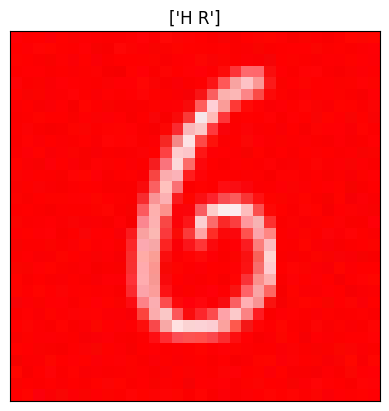

3


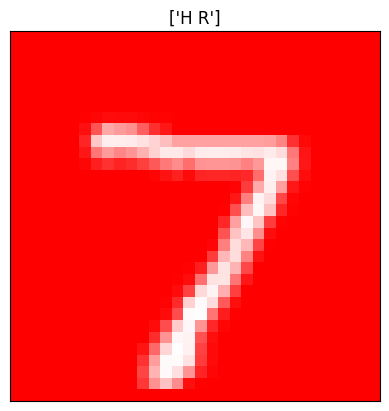

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.38it/s]


['C G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([2])
3


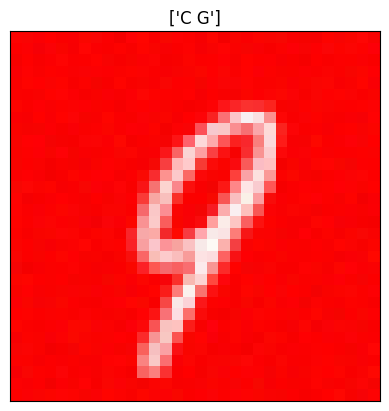

3


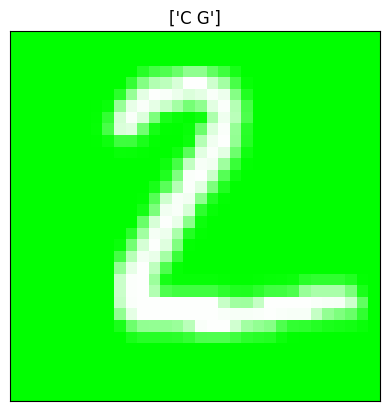

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.26it/s]


['B G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([1])
3


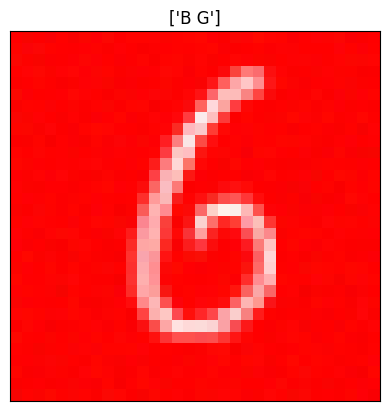

3


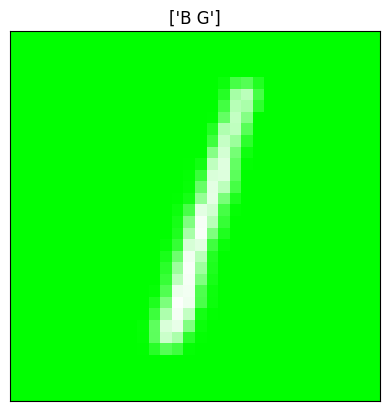

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.16it/s]


['A G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([0])
3


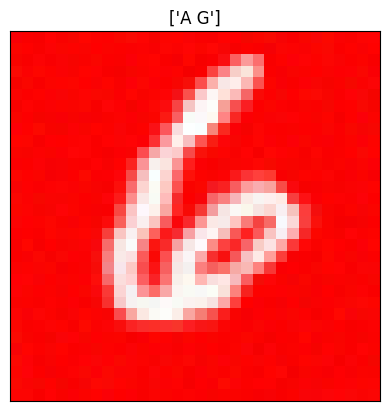

3


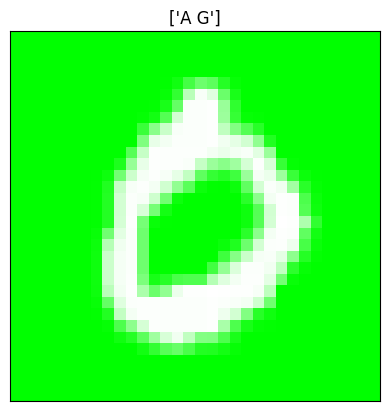

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.33it/s]


['E G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([4])
3


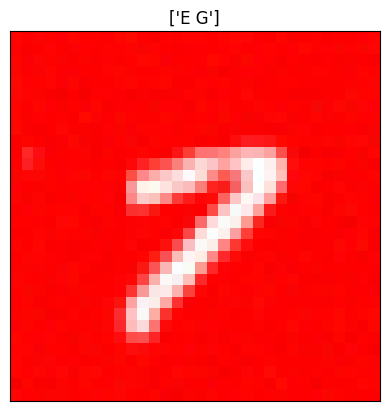

3


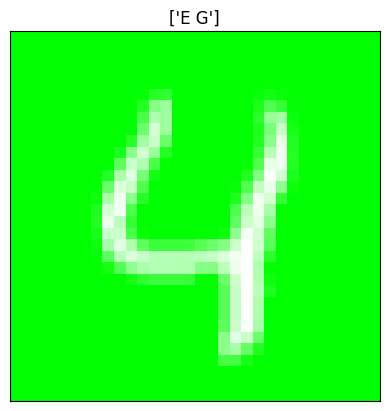

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.19it/s]


['B G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([1])
3


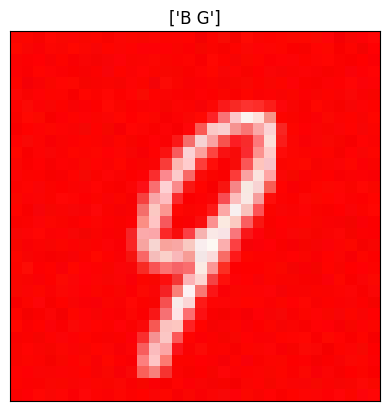

3


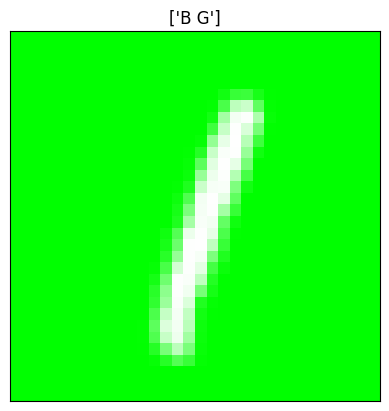

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.25it/s]


['E G']
[tensor([0]), tensor([255]), tensor([0])]
tensor([4])
3


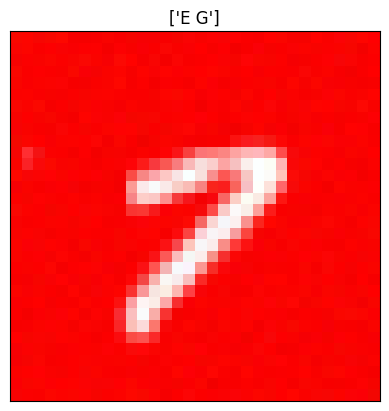

3


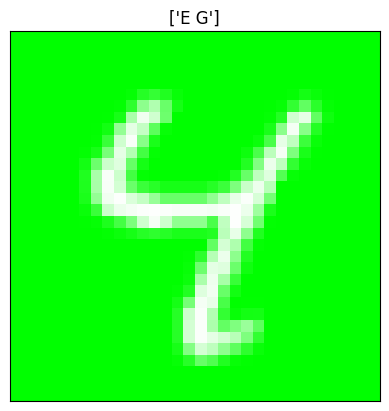

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.34it/s]


['J R']
[tensor([255]), tensor([0]), tensor([0])]
tensor([9])
3


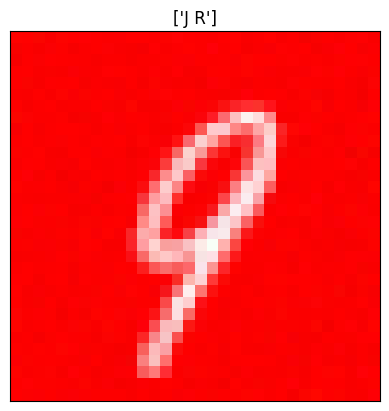

3


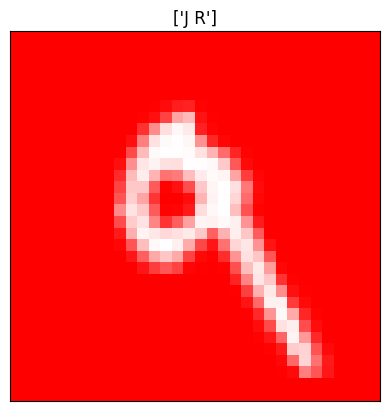

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.34it/s]


['F R']
[tensor([255]), tensor([0]), tensor([0])]
tensor([5])
3


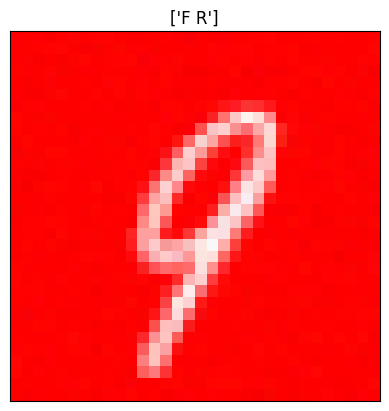

3


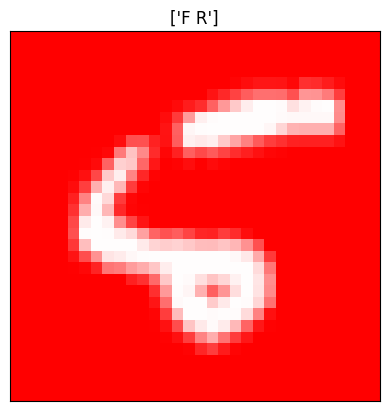

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:09<00:00, 21.36it/s]


['J R']
[tensor([255]), tensor([0]), tensor([0])]
tensor([9])
3


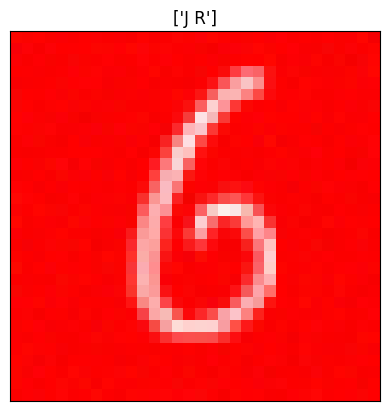

3


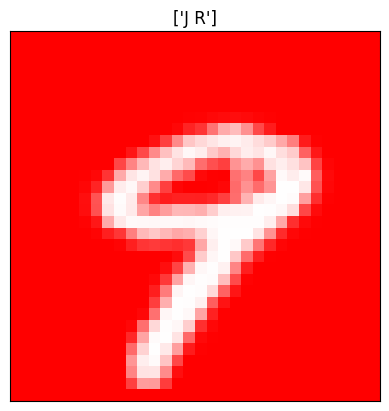

 21%|██████████████████████████████████████████████████                                                                                                                                                                                           | 42/199 [00:01<00:07, 21.17it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

# Get random characters for labels
# label_characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
# color_characters = ['R', 'G', 'B', 'Y', 'C', 'M', 'M', 'O', 'G', 'T']

def show(imgs):
    print(len(imgs))
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for batch in test_dataloader:
    out = visualize(unet, text_encoder, tokenizer, batch["color"], batch["label"], batch["prompt"])
    grid = make_grid(out)
    print(batch["prompt"])
    print(batch['color'])
    print(batch['label'])
    show(grid)
    plt.title(batch['prompt'])
    plt.show()
    grid = make_grid(batch['image'])
    show(grid)
    plt.title(batch['prompt'])
    plt.show()
    # break

In [8]:
out.shape

torch.Size([1, 3, 32, 32])